# Import library

In [1]:
from tqdm import tqdm # library to show progress bar
import pickle # library to load/dump binary file
import matplotlib.pyplot as plt

# Global function

In [2]:
def printPath(path):
    for i in path:
        print(f"{i['eng']:<40}{i['thai']:<40}{i['choice']:<20}")

In [3]:
def readFile(filePath):
    f = open(filePath, "rb") #สั่งเปิดไฟล์
    file = pickle.load(f) # load ไฟล์
    f.close() #สั่งปิดไฟล์
    
    return file

# Import dictionary thai-english & english-thai

In [4]:
thai_dic = readFile("./dictionary/thai_test_set_dictionary.pkl") # อ่านไฟล์ thai dictionary
eng_dic = readFile("./dictionary/eng_dictionary_new.pkl") # อ่านไฟล์ english dictionary

# Import sentences thai & english

In [5]:
def readSentences(filePath, NER=False):

    file = readFile(filePath)
    
    if NER: # case ที่ มี NER tag ในข้อมูลด้วย
        sents = []
        ners = []
        for i in file:
            sent = []
            ner = []
            for j in i:
                sent.append(j[0])
                ner.append(j[1])
            sents.append(sent)
            ners.append(ner)
        return sents, ners
    else: # case ที่ ไม่มี NER tag ในข้อมูลด้วย
        return file

# Edit distance

### No NER case (case #0)

In [6]:
def editDistDP(eng_sentence, thai_sentence, findPath=False): 
    
    # initial variable
    m = len(eng_sentence)
    n = len(thai_sentence)
    dp = [[0 for x in range(n + 1)] for x in range(m + 1)] # Create a table to store results of subproblems
    if findPath: # ถ้าอยากดู path
        path = [[[] for x in range(n + 1)] for x in range(m + 1)]
    
    # check empty sentence
    if (not eng_sentence) or (not thai_sentence):
        return 9999
    
    # local function
    def PathFindding(m, n):
        minimumPath = []
        a, b = m, n
        while a > 0 and b > 0:
            minimumPath.insert(0, {'eng':eng_sentence[a-1], 'thai':thai_sentence[b-1], 'choice': path[a][b]})
            choice = min(dp[a][b-1],        # Insert
                        dp[a-1][b],         # Remove
                        dp[a-1][b-1])       # Replace
            if choice == dp[a][b-1]:
                b = b-1
            elif choice == dp[a-1][b]:
                a = a-1
            elif choice == dp[a-1][b-1]:
                a = a-1
                b = b-1
            else:
                a = a-1
                b = b-1 
        return minimumPath
    
    def scoring(i, j):
        # initial variable
        score = 0 # score ของความเหมือน (โดยยิ่งน้อยยิ่งเหมือน range = [0,1])
        same_meaning = 0 # ตัวแปรเก็บจำนวนความเหมือนของความหมาย
        num_thai_meaning = 0 # จำนวนความหมาย
        num_english_meaning = 0 # จำนวนความหมาย

        # if a word have meaning in dictionary
        try:
            # เก็บจำนวนความหมาย
            num_english_meaning = len(eng_dic[eng_sentence[i-1].lower()])
            num_thai_meaning = len(thai_dic[thai_sentence[j-1]])

            # ถ้ามีความหมายตรงกันหมดให้คะแนนเต็มไปเลย
            if thai_dic[thai_sentence[j-1]] == eng_dic[eng_sentence[i-1]]:
                score = 0
            # ถ้าไม่เหมือนหมดจะหาจำนวนความหมายที่เหมือนแล้วนำไปคิดคะแนนต่อไป
            else:
                for thai_meaning in thai_dic[thai_sentence[j-1]]:
                    for eng_meaning in eng_dic[eng_sentence[i-1]]:
                        if thai_meaning == eng_meaning:
                            same_meaning += 1
                            break

                # ช่วงคิดคะแนน
                # ไม่มีความหมายที่ตรงกันเลย
                if same_meaning == 0:
                    score = 1
                # มีอย่างน้อย 1 ความหมายที่ตรงกัน
                else:
                    score = 0
#                     score = 1 - (same_meaning / (same_meaning + (len(thai_dic[thai_sentence[j-1]]) - same_meaning) + (len(eng_dic[eng_sentence[i-1]]) - same_meaning)))

        # if a word doesn't have meaning in dictionary       
        # Note: ตรงนี้อาจจะต้องปรับแก้
        except:
            score = 1
            return score, False
        
        return score, same_meaning != 0 # case แค่เหมือนตัวเดียวเอาเลย
#         return score, (num_thai_meaning - same_meaning == 0 and num_english_meaning - same_meaning == 0)
                
    # Edit distance
    for i in range(m + 1):
        for j in range(n + 1):
 
            # my score
            score, copy_check = scoring(i, j)

            # If first sentence is empty, only option is to
            # insert all words of second sentence
            if i == 0:
                dp[i][j] = j   # Min. operations = j
 
            # If second sentence is empty, only option is to
            # remove all words of second sentence
            elif j == 0:
                dp[i][j] = i   # Min. operations = i
 
            # If last word have same meaning, ignore last char
            # and recur for remaining sentence
            elif copy_check:
                dp[i][j] = dp[i-1][j-1]
                if findPath:
                    path[i][j] = 'Copy'
 
            # If last word are different meaning, consider all
            # possibilities and find minimum
            else:
                choice = min(dp[i][j-1],        # Insert
                             dp[i-1][j],        # Remove
                             dp[i-1][j-1])      # Replace
                dp[i][j] = score + choice
                if findPath:
                    if choice == dp[i][j-1]:
                        path[i][j] = 'Insert'
                    elif choice == dp[i-1][j]:
                        path[i][j] = 'Remove'
                    else:
                        path[i][j] = 'Replace'
                
    if findPath:
        return dp[m][n], PathFindding(m, n)
    else:
        return dp[m][n]

### With NER case (case #1)

In [7]:
def editDistDP_NER(eng_sentence, thai_sentence, eng_ner, thai_ner, findPath=False): 
    
    # initial variable
    m = len(eng_sentence)
    n = len(thai_sentence)
    dp = [[0 for x in range(n + 1)] for x in range(m + 1)] # Create a table to store results of subproblems
    if findPath: # ถ้าอยากดู path
        path = [['' for x in range(n + 1)] for x in range(m + 1)]
    
    # check empty sentence
    if (not eng_sentence) or (not thai_sentence):
        return 9999
    
    # local function
    def PathFindding(m, n):
        minimumPath = []
        a, b = m, n
        while a > 0 and b > 0:
            minimumPath.insert(0, {'eng':eng_sentence[a-1], 'thai':thai_sentence[b-1], 'choice': path[a][b]})
            choice = min(dp[a][b-1],        # Insert
                        dp[a-1][b],         # Remove
                        dp[a-1][b-1])       # Replace
            if choice == dp[a][b-1]:
                b = b-1
            elif choice == dp[a-1][b]:
                a = a-1
            elif choice == dp[a-1][b-1]:
                a = a-1
                b = b-1
            else:
                a = a-1
                b = b-1 
        return minimumPath
    
    def scoring(i, j):
        # initial variable
        score = 0 # score ของความเหมือน (โดยยิ่งน้อยยิ่งเหมือน range = [0,1])
        same_meaning = 0 # ตัวแปรเก็บจำนวนความเหมือนของความหมาย
        num_thai_meaning = 0 # จำนวนความหมาย
        num_english_meaning = 0 # จำนวนความหมาย

        # if a word have meaning in dictionary
        try:
            # เก็บจำนวนความหมาย
            num_english_meaning = len(eng_dic[eng_sentence[i-1].lower()])
            num_thai_meaning = len(thai_dic[thai_sentence[j-1]])

            # ถ้ามีความหมายตรงกันหมดให้คะแนนเต็มไปเลย
            if thai_dic[thai_sentence[j-1]] == eng_dic[eng_sentence[i-1]]:
                score = 0
            # ถ้าไม่เหมือนหมดจะหาจำนวนความหมายที่เหมือนแล้วนำไปคิดคะแนนต่อไป
            else:
                for thai_meaning in thai_dic[thai_sentence[j-1]]:
                    for eng_meaning in eng_dic[eng_sentence[i-1]]:
                        if thai_meaning == eng_meaning:
                            same_meaning += 1
                            break

                # ช่วงคิดคะแนน
                # ไม่มีความหมายที่ตรงกันเลย
                if same_meaning == 0:
                    score = 1
                # มีอย่างน้อย 1 ความหมายที่ตรงกัน
                else:
#                     if num_thai_meaning == same_meaning:
                    score = 0
#                     else:
#                         alpha = 0.90
#                     score = 1 - (same_meaning / (same_meaning + (alpha * (len(thai_dic[thai_sentence[j-1]]) - same_meaning)) + ((1 - alpha) * (len(eng_dic[eng_sentence[i-1]]) - same_meaning))))

        # if a word doesn't have meaning in dictionary       
        # Note: ตรงนี้อาจจะต้องปรับแก้
        except:
            if (eng_ner[i-1] == thai_ner[j-1]) and eng_ner[i-1] != 'O' and thai_ner[j-1] != 'O':
                return 0, True
            else:
                return 1, False
                
        return score, same_meaning != 0 # case แค่เหมือนตัวเดียวเอาเลย
#         return score, (num_thai_meaning - same_meaning == 0 and num_english_meaning - same_meaning == 0) # case ดูอัตราส่วน
#         return score, num_thai_meaning == same_meaning # case ดูความหมายไทยเป็นหลัก
                
    # Edit distance
    for i in range(m + 1):
        for j in range(n + 1):
 
            # my score
            score, copy_check = scoring(i, j)

            # If first sentence is empty, only option is to
            # insert all words of second sentence
            if i == 0:
                dp[i][j] = j   # Min. operations = j
 
            # If second sentence is empty, only option is to
            # remove all words of second sentence
            elif j == 0:
                dp[i][j] = i   # Min. operations = i
 
            # If last word have same meaning, ignore last char
            # and recur for remaining sentence
            elif copy_check:
                dp[i][j] = dp[i-1][j-1]
                if findPath:
                    path[i][j] = 'Copy'
 
            # If last word are different meaning, consider all
            # possibilities and find minimum
            else:
                choice = min(dp[i][j-1],        # Insert
                             dp[i-1][j],        # Remove
                             dp[i-1][j-1])      # Replace
                dp[i][j] = score + choice
                    
                if findPath:
                    if choice == dp[i][j-1]:
                        path[i][j] = 'Insert'
                    elif choice == dp[i-1][j]:
                        path[i][j] = 'Remove'
                    else:
                        path[i][j] = 'Replace'
                
    if findPath:
        return dp[m][n], PathFindding(m, n)
    else:
        return dp[m][n]

### NP Chunking (case #2)

In [8]:
def editDistDP_NP(eng_sentence, thai_sentence, eng_ner, thai_ner, findPath=False): 
    
    # initial variable
    m = len(eng_sentence)
    n = len(thai_sentence)
    dp = [[0 for x in range(n + 1)] for x in range(m + 1)] # Create a table to store results of subproblems
    if findPath: # ถ้าอยากดู path
        path = [['' for x in range(n + 1)] for x in range(m + 1)]
    
    # check empty sentence
    if (not eng_sentence) or (not thai_sentence):
        return 9999
    
    # local function
    def PathFindding(m, n):
        minimumPath = []
        a, b = m, n
        while a > 0 and b > 0:
            minimumPath.insert(0, {'eng':eng_sentence[a-1], 'thai':thai_sentence[b-1], 'choice': path[a][b]})
            choice = min(dp[a][b-1],        # Insert
                        dp[a-1][b],         # Remove
                        dp[a-1][b-1])       # Replace
            if choice == dp[a][b-1]:
                b = b-1
            elif choice == dp[a-1][b]:
                a = a-1
            elif choice == dp[a-1][b-1]:
                a = a-1
                b = b-1
            else:
                a = a-1
                b = b-1 
        return minimumPath
    
    def scoring(i, j):
        # initial variable
        score = 0 # score ของความเหมือน (โดยยิ่งน้อยยิ่งเหมือน range = [0,1])
        same_meaning = 0 # ตัวแปรเก็บจำนวนความเหมือนของความหมาย
        num_thai_meaning = 0 # จำนวนความหมาย
        num_english_meaning = 0 # จำนวนความหมาย

        # if a word have meaning in dictionary
        try:
            # เก็บจำนวนความหมาย
            num_english_meaning = len(eng_dic[eng_sentence[i-1].lower()])
            num_thai_meaning = len(thai_dic[thai_sentence[j-1]])

            # ถ้ามีความหมายตรงกันหมดให้คะแนนเต็มไปเลย
            if thai_dic[thai_sentence[j-1]] == eng_dic[eng_sentence[i-1]]:
                score = 0
            # ถ้าไม่เหมือนหมดจะหาจำนวนความหมายที่เหมือนแล้วนำไปคิดคะแนนต่อไป
            else:
                for thai_meaning in thai_dic[thai_sentence[j-1]]:
                    for eng_meaning in eng_dic[eng_sentence[i-1]]:
                        if thai_meaning == eng_meaning:
                            same_meaning += 1
                            break

                # ช่วงคิดคะแนน
                # ไม่มีความหมายที่ตรงกันเลย
                if same_meaning == 0:
                    score = 1
                # มีอย่างน้อย 1 ความหมายที่ตรงกัน
                else:
                    score = 0
#                     score = 1 - (same_meaning / (same_meaning + (len(thai_dic[thai_sentence[j-1]]) - same_meaning) + (len(eng_dic[eng_sentence[i-1]]) - same_meaning)))

        # if a word doesn't have meaning in dictionary       
        # Note: ตรงนี้อาจจะต้องปรับแก้
        except:
            if eng_ner[i-1] != 'O' and thai_ner[j-1] != 'O':
                for ttype in ['DATE', 'TIME', 'LEN', 'PERSON', 'Money', 'LAW']:
                    if ttype in set(eng_ner[i-1]).intersection(set(thai_ner[j-1])):
                        score = 0
                        return score, True
            else:
                score = 1
                return score, False
            
        return score, same_meaning != 0
#         return score, (num_thai_meaning - same_meaning == 0 and num_english_meaning - same_meaning == 0)
                
    # Edit distance
    for i in range(m + 1):
        for j in range(n + 1):
 
            # my score
            score, copy_check = scoring(i, j)

            # If first sentence is empty, only option is to
            # insert all words of second sentence
            if i == 0:
                dp[i][j] = j   # Min. operations = j
 
            # If second sentence is empty, only option is to
            # remove all words of second sentence
            elif j == 0:
                dp[i][j] = i   # Min. operations = i
 
            # If last word have same meaning, ignore last char
            # and recur for remaining sentence
            elif copy_check:
                dp[i][j] = dp[i-1][j-1]
                if findPath:
                    path[i][j] = 'Copy'
 
            # If last word are different meaning, consider all
            # possibilities and find minimum
            else:
                choice = min(dp[i][j-1],        # Insert
                             dp[i-1][j],        # Remove
                             dp[i-1][j-1])      # Replace
                dp[i][j] = score + choice
                if findPath:
                    if choice == dp[i][j-1]:
                        path[i][j] = 'Insert'
                    elif choice == dp[i-1][j]:
                        path[i][j] = 'Remove'
                    else:
                        path[i][j] = 'Replace'
                
    if findPath:
        return dp[m][n], PathFindding(m, n)
    else:
        return dp[m][n]

# Main program

In [9]:
read_ner = True

In [10]:
thai_file_path = "./data/thai_sent_NER.data"
if read_ner:
    thai_sents, thai_ners = readSentences(thai_file_path, read_ner)
else:
    thai_sents = readSentences(thai_file_path, read_ner)

In [11]:
eng_file_path = "./data/eng_sent_stanfordNER.data"
if read_ner:
    eng_sents, eng_ners = readSentences(eng_file_path, read_ner)
else:
    eng_sents = readSentences(eng_file_path, read_ner)

In [12]:
num = 0
thai_sentence = thai_sents[num]
eng_sentence = eng_sents[num]

score, path = editDistDP(eng_sentence, thai_sentence, True)
score

33

In [13]:
printPath(path)

far                                     ซ้าย                                    Replace             
left                                    ซ้าย                                    Copy                
indonesian national police              สุด                                     Replace             
chief                                   นายติโต คาร์นาเวียน                     Replace             
tito karnavian                          ผู้บัญชาการ                             Replace             
from                                    ตำรวจแห่งชาติอินโดนีเซีย                Replace             
left                                    จาก                                     Replace             
left                                    ซ้าย                                    Copy                
philippine national police              นายโรนัลด์ เดลา โรซา                    Replace             
chief                                   ผู้บัญชาการ                             Replace    

In [14]:
num = 0
thai_sentence = thai_sents[num]
thai_ner = thai_ners[num]
eng_sentence = eng_sents[num]
eng_ner = eng_ners[num]

score, path =  editDistDP_NER(eng_sentence, thai_sentence, eng_ner, thai_ner, True)

score

31

In [15]:
printPath(path)

far                                     ซ้าย                                    Replace             
left                                    ซ้าย                                    Copy                
indonesian national police              สุด                                     Replace             
chief                                   นายติโต คาร์นาเวียน                     Replace             
tito karnavian                          นายติโต คาร์นาเวียน                     Copy                
from                                    ผู้บัญชาการ                             Replace             
left                                    ตำรวจแห่งชาติอินโดนีเซีย                Replace             
philippine national police              ตำรวจแห่งชาติอินโดนีเซีย                Copy                
chief                                   จาก                                     Replace             
ronald dela rosa                        ซ้าย                                    Replace    

# Evaluate

In [16]:
import random

In [17]:
# กำหนด seed เพื่อสุ่ม 1000 ประโยคภาษาอังกฤษ
N = 1000 # จำนวนประโยคภาษาไทยที่จะสุ่ม

seed = [x for x in range(N)] 

random.seed(1999)
thai_sents_sample = random.sample(range(len(thai_sents)), N)

In [18]:
eng_sents_sample = []
for i in range(N):
    random.seed(i)
    eng_index = random.sample(range(len(eng_sents)), 1000)
    eng_index.append(thai_sents_sample[i])
    eng_index = list(set(eng_index))
    if len(eng_index) > 1000:
        if eng_index[0] == thai_sents_sample[i]:
            eng_index.pop(1)
        else:
            eng_index.pop(0)
    eng_sents_sample.append(eng_index)

In [19]:
# Check
total = 0
for i, j in zip(thai_sents_sample, eng_sents_sample):
    if i in j:
        total += 1
total 

1000

In [24]:
def evaluate(case=0):
    count = {} # เอาไว้วัด acc
    for eng_index, thai_index in tqdm(zip(eng_sents_sample, thai_sents_sample)):
        similarity = {}
        key_min = ''
        if case == 0:
            for index in eng_index: # index = one of eng_index
                similarity[index] = editDistDP(eng_sents[index],
                                               thai_sents[thai_index],
                                              )
        elif case == 1:
            for index in eng_index: # index = one of eng_index
                if abs(len(eng_sents[index]) - len(thai_sents[thai_index])) < round(len(thai_sents[thai_index])*(2/3)):
                    similarity[index] = editDistDP_NER(eng_sents[index],
                                                       thai_sents[thai_index],
                                                       eng_ners[index],
                                                       thai_ners[thai_index]
                                                      )
                else:
                    similarity[index] = len(eng_sents[index]) + len(thai_sents[thai_index])
        elif case == 2:
            for index in eng_index: # index = one of eng_index
                similarity[index] = editDistDP_NP( eng_sents[index],
                                                   thai_sents[thai_index],
                                                   eng_ners[index],
                                                   thai_ners[thai_index]
                                                  )

        sorted_tuples = sorted(similarity.items(), key=lambda item: item[1])
        sorted_similarity = {}
        prev = 0
        rank = 0
        for i, v in enumerate(sorted_tuples):
            if v[1] != prev:
                sorted_similarity[v[0]] = (i, v[1])
                rank = i
            else:
                sorted_similarity[v[0]] = (rank, v[1])
            prev = v[1]

        print("Index ประโยคภาษาไทย: " + str(thai_index))
        print("ประโยค: " + ''.join(thai_sents[thai_index]))

        print("Same index: " + str(thai_index) + " Value: " + str(sorted_similarity[thai_index][1]))
        print("Sentence: " + ' '.join(eng_sents[thai_index]))

        print("Minimum index: " + str(list(sorted_similarity)[0]) + " Value: " + str(sorted_similarity[list(sorted_similarity)[0]][1]))
        print("Sentence: " + ' '.join(eng_sents[list(sorted_similarity)[0]]))
        print("========================================")

        pos = sorted_similarity[thai_index][0]
        if pos in count:
            count[pos] += 1
        else:
            count[pos] = 1
    return count

In [25]:
count = evaluate(1)


0it [00:00, ?it/s]

Index ประโยคภาษาไทย: 122618
ประโยค: จะแนะนำของนี่ค่ะ
Same index: 122618 Value: 5
Sentence: i would recommend this item
Minimum index: 636936 Value: 5
Sentence: yes that should good



2it [00:00,  3.22it/s]
4it [00:00,  4.27it/s]

Index ประโยคภาษาไทย: 371094
ประโยค: คุณไม่มีทางเลือกหลังจากนั้นเว้นแต่คุณจะเป็นหนึ่งในศิลปินที่ไม่รู้จักที่ยิ่งใหญ่ที่มาพร้อมกับคุณ
Same index: 371094 Value: 22
Sentence: you really have no choice after that unless it 's from one of those great unknown artist that come along and hook you
Minimum index: 356814 Value: 17
Sentence: i 'm so disapointed because she did not complete her book
Index ประโยคภาษาไทย: 149231
ประโยค: ต้องซื้ออันใหม่เพราะลูกสาวเราอยากได้
Same index: 149231 Value: 8
Sentence: had to get a new one because our daughter wanted it
Minimum index: 522259 Value: 7
Sentence: i bought newspaper already already
Index ประโยคภาษาไทย: 760404
ประโยค: ขอพิซซาสมีทเลิฟเวอร์ แล้วก็บรอคโคลีพิเศษชีสค่ะ
Same index: 760404 Value: 18
Sentence: can i get a meat lover and a broccoli pizza with extra cheese
Minimum index: 728937 Value: 4
Sentence: with something extra



5it [00:00,  4.19it/s]
6it [00:01,  4.86it/s]

Index ประโยคภาษาไทย: 593846
ประโยค: การขนส่งสินค้าชีวภาพทางบกถูกห้ามในประเทศจีนประกาศณวันที่20 ธันวาคม 2562
Same index: 593846 Value: 14
Sentence: biological commodity prohibited from transiting china on road posted on december 20 , 2019 created with sketch
Minimum index: 518298 Value: 11
Sentence: in march 67 percent connected through cable up from 63 percent a year earlier
Index ประโยคภาษาไทย: 521957
ประโยค: ได้ยังไงกันฝนยังตกอยู่อีกหรอ
Same index: 521957 Value: 8
Sentence: how izzit still raining
Minimum index: 485426 Value: 8
Sentence: okay i will not be concerned


KeyboardInterrupt: 

In [41]:
num = 0     
com = 0          
thai_sentence = thai_sents[num]
thai_ner = thai_ners[num]
eng_sentence = eng_sents[com]
eng_ner = eng_ners[com]

score, path =  editDistDP_NER(eng_sentence, thai_sentence, eng_ner, thai_ner, True)

printPath(path)

far                                     ซ้าย                                    Replace             
left                                    ซ้าย                                    Copy                
indonesian national police              สุด                                     Replace             
chief                                   นายติโต คาร์นาเวียน                     Replace             
tito karnavian                          นายติโต คาร์นาเวียน                     Copy                
from                                    ผู้บัญชาการ                             Replace             
left                                    ตำรวจแห่งชาติอินโดนีเซีย                Replace             
philippine national police              ตำรวจแห่งชาติอินโดนีเซีย                Copy                
chief                                   จาก                                     Replace             
ronald dela rosa                        ซ้าย                                    Replace    

In [42]:
thai_dic['แขน']

['arm']

In [43]:
eng_dic['arm']

['weapon', 'sleeve', 'branch', 'arm']

In [60]:
sorted_tuples = sorted(count.items(), key=lambda item: item[0])
sorted_count = {k: v for k, v in sorted_tuples}

In [61]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Amount')

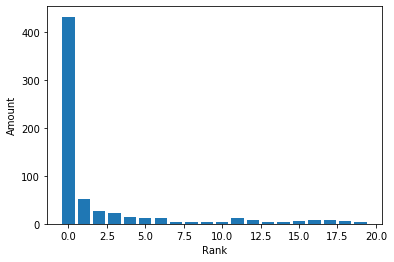

In [62]:
plt.bar(list(sorted_count.keys())[0:20], list(sorted_count.values())[0:20])
plt.xlabel('Rank')
plt.ylabel('Amount')

In [63]:
range0 = 0
range1_4 = 0
range5_9 = 0
range10_19 = 0
for i, v in list(sorted_count.items())[0:19]:
    if i == 0:
        range0 += v
    elif i>=1 and i<=4:
        range1_4 += v
    elif i>=5 and i<=9:
        range5_9 += v
    else:
        range10_19 += v
        
print(f"Top1:     {(range0 / N)*100:.2f} %")
print(f"Top2-5:   {(range1_4 / N)*100:.2f} %")
print(f"Top5-10:  {(range5_9 / N)*100:.2f} %")
print(f"Top11-20: {(range10_19 / N)*100:.2f} %")

Top1:     43.30 %
Top2-5:   11.40 %
Top5-10:  3.60 %
Top11-20: 5.30 %
